# Defining Parameters

* **Data**: Structured

In [1]:
scoring_metric = 'f1_weighted'
max_iter_log = 500

#Randomized Search Metric
n_iter_search = 25

# Library Calls

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import feather
import nltk
import re
import string
import sklearn
import matplotlib.pyplot as plt

from scipy.stats import randint as sp_randint
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV,  cross_val_score, cross_validate

from sklearn.svm import SVC, OneClassSVM 
from sklearn.ensemble import IsolationForest

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score,precision_recall_fscore_support
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
from sklearn.metrics import confusion_matrix

# Random State
rng = np.random.RandomState(5590)
solver_log = 'saga'

# Data Import and Processing

We define the dataframes as none for a subsqent check.

In [3]:
path = './data/df_structured_export.feather'

df = feather.read_dataframe(path)

# Define Data Frame

Here we do a check to see which data frame we are analyzing, All Notes or Discharge Notes

In [4]:
# if df_all is not None:
#     df = df_all
# else:
#     df = df_ds
      
# Convert HADMID to String
df.hadm_id = df.hadm_id.astype('int64').astype(str)

# Convert Readmit_30 to Int
df.readmit_30 = df.readmit_30.astype('int')

In [5]:
df.shape

(43875, 45)

We need to drop the id variables.

In [6]:
df.drop(columns = ['hadm_id', 'subject_id'], inplace=True)

In [7]:
df.head().T

,0,1,2,3,4
readmit_30,0.00000,0.000000,0.000000,0.000000,0.000000
age_yr,65.00000,71.200000,75.300000,39.000000,59.000000
length_stay_hr_log,4.78136,7.043301,7.343408,6.100137,6.405992
icu_stay,1.00000,1.000000,1.000000,1.000000,1.000000
albumin_test,0.00000,0.000000,1.000000,0.000000,1.000000
albumin_flag,0.00000,0.000000,0.000000,0.000000,1.000000
calcium_test,1.00000,1.000000,1.000000,1.000000,1.000000
calcium_flag,0.00000,1.000000,1.000000,0.000000,1.000000
magnesium_test,1.00000,1.000000,1.000000,1.000000,1.000000
magnesium_flag,0.00000,0.000000,0.000000,0.000000,0.000000


# Functions

In [8]:
def data_split(df):
    # Split into Train, Valid and Test
    ## Shuffle
    df = df.sample(n = len(df), random_state= rng)
    df = df.reset_index(drop = True)
    
    ## Extract Data for Test and Valid Sampling
    df_v_te = df.sample(frac=0.40, random_state = rng)
    
    ## Test Sample
    df_te = df_v_te.sample(frac = 0.5, random_state = rng)
    
    ## Valid Sample
    df_v = df_v_te.drop(df_te.index)

    ## Training Sample
    df_tr = df.drop(df_v_te.index)
    

#     x_tr = df_tr.drop(columns = ['readmit_30'])
#     x_v = df_v.drop(columns = ['readmit_30'])
#     x_te  = df_te.drop(columns = ['readmit_30'])
    
#     # Define Target Variables
#     y_tr = df_tr.readmit_30
#     y_v = df_v.readmit_30
#     y_te = df_te.readmit_30
    
    return df_tr, df_v, df_te

## Model Output

### Scoring Metrics
The following functions calculate the scoring metrics the models will be evlauted on.

In [9]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def calc_prevalence(y_actual):
    # calculates prevalence
    return sum((y_actual == 1)) /len(y_actual)

### Scoring Output
The following code generates the visual output of the scoring metrics.

In [10]:
def roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds):
    
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_tr, y_tr_preds)
    fpr_v, tpr_v, thresholds_v = roc_curve(y_v, y_v_preds)
    
    plt.plot(fpr_tr, tpr_tr,'r-', label = 'Train AUC: %.2f'%roc_auc_score(y_tr, y_tr_preds))
    plt.plot(fpr_v, tpr_v,'b-',label = 'Valid AUC: %.2f'%roc_auc_score(y_v, y_v_preds))
    plt.plot([0,1],[0,1],'-k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

### Confusion Matrix

In [11]:
def pretty_cm(y_pred, y_truth, labels):
    '''
    'Pretty' implementation of a confusion matrix with some evaluation statistics.
    
    Input:
    y_pred - object with class predictions from the model
    y_truth - object with actual classes
    labels - list containing label names
    '''
    
    cm = confusion_matrix(y_truth, y_pred)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt="d", linewidths=.5, square = True, cmap = 'BuGn_r')
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('Actual label')
    ax.set_title('Confusion Matrix', size = 15) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
    print('#######################')
    print('Evaluation metrics ####')
    print('#######################')
    print('Accuracy: {:.3f}'.format(accuracy_score(y_truth, y_pred)))
    print('AUC Score: {:.3f}'.format(roc_auc_score(y_truth, y_pred)))
    print('Precision: {:.3f}'.format(precision_score(y_truth, y_pred)))
    print('Precision Weighted: {:.3f}'.format(precision_score(y_truth, y_pred, average = 'weighted')))
    print('Recall: {:.3f}'.format(recall_score(y_truth, y_pred)))
    print('Recall Weighted: {:.3f}'.format(recall_score(y_truth, y_pred, average = 'weighted')))
    print('F1: {:.3f}'.format(f1_score(y_truth, y_pred)))
    print('F1 Weighted: {:.3f}'.format(f1_score(y_truth, y_pred, average = 'weighted')))
    print('Prevelance: {:.3f}'.format(calc_prevalence(y_truth)))

## Model Execution

The following function trains a default model to the training data and generates training and validation scores.

In [12]:
def train_model_default(clf, x_tr, x_v):
    
    clf.fit(x_tr, y_tr)

    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds)

The following function takes in the optimized model and generates training and validation scores


In [13]:
def opt_model_scoring(clf, x_tr, x_v):
    
    y_tr_preds = clf.predict_proba(x_tr)[:,1]
    y_v_preds = clf.predict_proba(x_v)[:,1]

    roc_curve_plot(y_tr, y_tr_preds, y_v, y_v_preds)

The following function runs the gridsearchcv

## Data Processing

Split the Data into train, validation, and test data sets.

In [14]:
df = df.sample(frac = 1, random_state = rng)
df_tr, df_v, df_te = data_split(df)

Split the training data into normal and outlier data.

In [15]:
df_tr_normal = df_tr[df_tr['readmit_30']==0]
df_tr_outlier = df_tr[df_tr['readmit_30']==1]

In [16]:
# Define Target Sets
x_tr_all = df_tr.drop(columns = ['readmit_30'])
x_tr_normal = df_tr_normal.drop(columns = ['readmit_30'])
x_tr_outlier = df_tr_outlier.drop(columns = ['readmit_30'])
x_v = df_v.drop(columns = ['readmit_30'])
x_te = df_te.drop(columns = ['readmit_30'])

# Define Target Variables
y_tr_all = df_tr.readmit_30
y_tr_normal = df_tr_normal.readmit_30
y_tr_outlier = df_tr_outlier.readmit_30
y_v = df_v.readmit_30
y_te = df_te.readmit_30

In [17]:
# Proportion of Outliers
outlier_prop = len(df_tr_outlier) / len(df_tr_normal) 

## Modeling - Default Settings

### One Class SVM

One class SVM trains the model on only normal (non-readmit) data. Then predicts on full data.

In [18]:
clf = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma = 0.000001) 

In [19]:
clf.fit(x_tr_normal)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma=1e-06, kernel='rbf',
            max_iter=-1, nu=0.05927088363109609, random_state=None,
            shrinking=True, tol=0.001, verbose=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.888
AUC Score: 0.496
Precision: 0.048
Precision Weighted: 0.893
Recall: 0.054
Recall Weighted: 0.888
F1: 0.051
F1 Weighted: 0.891
Prevelance: 0.056


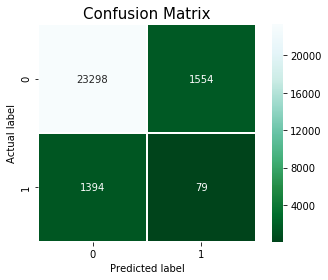

In [20]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.885
AUC Score: 0.497
Precision: 0.054
Precision Weighted: 0.889
Recall: 0.058
Recall Weighted: 0.885
F1: 0.056
F1 Weighted: 0.887
Prevelance: 0.059


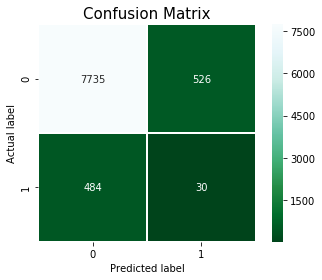

In [21]:
# Validation
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

### Isolation Forest

#### Fit on No-Outlier Data

In [22]:
iforest = IsolationForest(max_samples=100, random_state=rng, contamination= outlier_prop,  behaviour="new", verbose = 1)

iforest.fit(x_tr_normal)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.05927088363109609, max_features=1.0,
                max_samples=100, n_estimators=100, n_jobs=None,
                random_state=<mtrand.RandomState object at 0x000001D0D257C750>,
                verbose=1, warm_start=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.890
AUC Score: 0.492
Precision: 0.041
Precision Weighted: 0.893
Recall: 0.043
Recall Weighted: 0.890
F1: 0.042
F1 Weighted: 0.892
Prevelance: 0.056


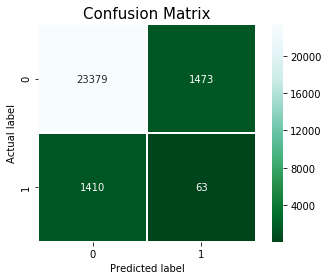

In [23]:
# Training
x = x_tr_all
y = y_tr_all
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.886
AUC Score: 0.493
Precision: 0.045
Precision Weighted: 0.888
Recall: 0.047
Recall Weighted: 0.886
F1: 0.046
F1 Weighted: 0.887
Prevelance: 0.059


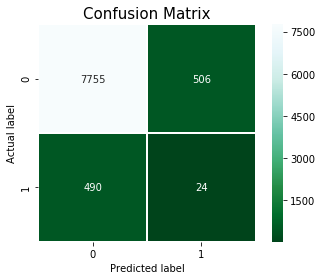

In [24]:
# Validation
x = x_v
y = y_v
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

#### Fit on All Data

In [25]:
iforest = IsolationForest(max_samples=100, random_state=rng, contamination= outlier_prop,  behaviour="new", verbose = 1)

iforest.fit(x_tr_all)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s finished


IsolationForest(behaviour='new', bootstrap=False,
                contamination=0.05927088363109609, max_features=1.0,
                max_samples=100, n_estimators=100, n_jobs=None,
                random_state=<mtrand.RandomState object at 0x000001D0D257C750>,
                verbose=1, warm_start=False)

#######################
Evaluation metrics ####
#######################
Accuracy: 0.889
AUC Score: 0.490
Precision: 0.038
Precision Weighted: 0.892
Recall: 0.041
Recall Weighted: 0.889
F1: 0.040
F1 Weighted: 0.891
Prevelance: 0.056


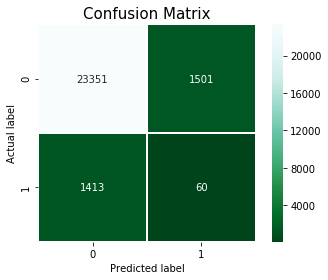

In [26]:
# Training
x = x_tr_all
y = y_tr_all
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_tr_pred = pd.Series(y_pred)
pretty_cm(y_tr_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.889
AUC Score: 0.488
Precision: 0.035
Precision Weighted: 0.887
Recall: 0.033
Recall Weighted: 0.889
F1: 0.034
F1 Weighted: 0.888
Prevelance: 0.059


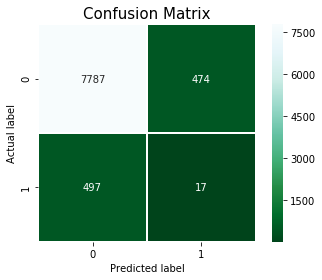

In [27]:
# Validation
x = x_v
y = y_v
clf = iforest
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

### Visual Method
The following method is based on generating a histogram of scores and seeing if you can visually identify a cluster of outliers.

https://www.depends-on-the-definition.com/detecting-network-attacks-with-isolation-forests/

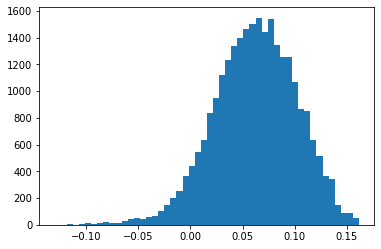

In [28]:
#Validation
scores = iforest.decision_function(x_tr_all)
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=50);

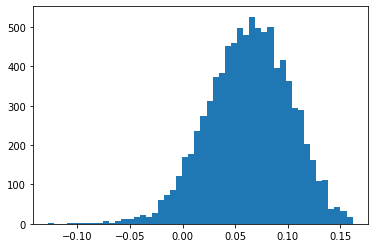

In [29]:
#Validation
scores = iforest.decision_function(x_v)
plt.figure(figsize=(6, 4))
plt.hist(scores, bins=50);

## Parameter Optimization

### One Class SVM

It is difficult and complicated to run a grid search for One Class SVM. The following code box is meant for manual adjustments of gamma.

#######################
Evaluation metrics ####
#######################
Accuracy: 0.907
AUC Score: 0.500
Precision: 0.058
Precision Weighted: 0.890
Recall: 0.039
Recall Weighted: 0.907
F1: 0.047
F1 Weighted: 0.898
Prevelance: 0.059


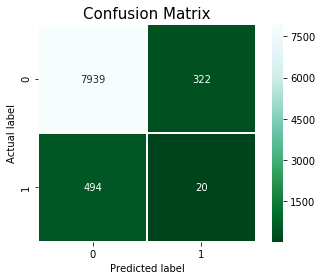

In [30]:
svm = OneClassSVM(kernel='rbf', nu=outlier_prop, gamma = 1e-9) 

svm.fit(x_tr_normal)

# Validation
x = x_v
y = y_v
y_pred = svm.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

The following method allows for One Class SVM to be looped over hyperparameters. 
Method based on:
https://stackoverflow.com/questions/44698928/is-there-a-way-to-perform-grid-search-hyper-parameter-optimization-on-one-class

In [31]:
# gammas = np.logspace(-9, 3, 13)
# nus = np.linspace(0.01, 0.1, 5)

# clf = OneClassSVM()

# results = []

# train_x = x_tr_normal
# valid_x = x_v


# for gamma in gammas:
#     for nu in nus:
#         clf.set_params(gamma=gamma, nu=nu)

#         clf.fit(train_x)

#         y_pred = clf.predict(valid_x)
        
#         y_pred = [1 if x == -1 else 0 for x in y_pred]

#         if 1. in y_pred:  # Check if at least 1 review is predicted to be in the class
#             results.append(((gamma, nu), (accuracy_score(y_true, y_pred),
#                                               precision_score(y_true, y_pred),
#                                               recall_score(y_true, y_pred),
#                                               f1_score(y_true, y_pred),
#                                               roc_auc_score(y_true, y_pred),
#                                               ))
#                                )

### Isoaltion Forest

#### AUC Score
Best Tuning Metric so far.

In [32]:
# Model
clf = IsolationForest(random_state=rng,  behaviour="new")

# Parameters
param_dist = {'n_estimators':sp_randint(100,400),
                   'max_samples': sp_randint(100,500), 
                   'contamination': [0.01, 0.05, 0.1, 0.2], 
                   'max_features': sp_randint(1,20), 
                   'bootstrap': [True, False]}

# Scorer
scorer = 'roc_auc'

# Number of Search
n_iter_search = n_iter_search

# Radomizer
random_if_estimator = RandomizedSearchCV(clf, 
                                       param_dist,
                                       n_iter = n_iter_search,
                                       scoring = scorer, 
                                       cv = 5,
                                       n_jobs = 4,
                                       verbose = 1,
                                       return_train_score = True)

In [33]:
random_if_estimator.fit(x_tr_all, y_tr_all)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  4.2min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x000001D0D257C750>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D0D4CA58D0>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D0D4CA55F8>,
                                      

In [34]:
print('Scorer')
print(random_if_estimator.scorer_)
print("")
print("Best Score")
print(random_if_estimator.best_score_)
print("")
print("Best Score Parameters")
print(random_if_estimator.best_params_)

Scorer
make_scorer(roc_auc_score, needs_threshold=True)

Best Score
0.5428949981491342

Best Score Parameters
{'bootstrap': False, 'contamination': 0.2, 'max_features': 19, 'max_samples': 116, 'n_estimators': 226}


In [35]:
clf_auc = random_if_estimator.best_estimator_
clf = clf_auc

#######################
Evaluation metrics ####
#######################
Accuracy: 0.762
AUC Score: 0.481
Precision: 0.046
Precision Weighted: 0.891
Recall: 0.164
Recall Weighted: 0.762
F1: 0.072
F1 Weighted: 0.819
Prevelance: 0.056


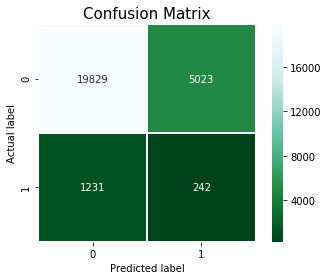

In [36]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.766
AUC Score: 0.468
Precision: 0.040
Precision Weighted: 0.885
Recall: 0.130
Recall Weighted: 0.766
F1: 0.061
F1 Weighted: 0.819
Prevelance: 0.059


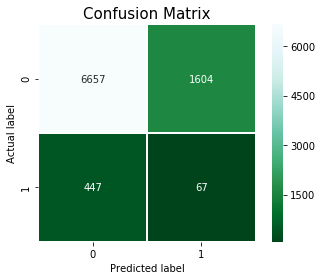

In [37]:
# Validation
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

### F1 Weighted
Ran once and performed poorly. Do not run again.

In [38]:
# Model
clf = IsolationForest(random_state=rng,  behaviour="new")

# Parameters
param_dist = {'n_estimators':sp_randint(100,400),
                   'max_samples': sp_randint(100,500), 
                   'contamination': [0.01, 0.05, 0.1, 0.2], 
                   'max_features': sp_randint(1,20), 
                   'bootstrap': [True, False]}

# Scorer
scorer = 'f1_weighted'

# Number of Search
n_iter_search = n_iter_search

# Radomizer
random_if_estimator = RandomizedSearchCV(clf, 
                                       param_dist,
                                       n_iter = n_iter_search,
                                       scoring = scorer, 
                                       cv=5,
                                       n_jobs = 4,
                                       verbose = 1,
                                       return_train_score = True)

In [39]:
random_if_estimator.fit(x_tr_all, y_tr_all)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=4)]: Done 125 out of 125 | elapsed:  4.6min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=IsolationForest(behaviour='new', bootstrap=False,
                                             contamination='legacy',
                                             max_features=1.0,
                                             max_samples='auto',
                                             n_estimators=100, n_jobs=None,
                                             random_state=<mtrand.RandomState object at 0x000001D0D257C750>,
                                             verbose=0, warm_start=False),
                   iid='warn', n_iter=25, n_jobs=4,
                   param_distributions={'bootstra...
                                        'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D0D47D49B0>,
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D0D47D4C88>,
                                      

In [40]:
print('Scorer')
print(random_if_estimator.scorer_)
print("")
print("Best Score")
print(random_if_estimator.best_score_)
print("")
print("Best Score Parameters")
print(random_if_estimator.best_params_)

Scorer
make_scorer(f1_score, pos_label=None, average=weighted)

Best Score
0.006162260735146947

Best Score Parameters
{'bootstrap': True, 'contamination': 0.2, 'max_features': 17, 'max_samples': 432, 'n_estimators': 388}


In [41]:
clf_f1 = random_if_estimator.best_estimator_
clf = clf_f1

#######################
Evaluation metrics ####
#######################
Accuracy: 0.762
AUC Score: 0.481
Precision: 0.046
Precision Weighted: 0.891
Recall: 0.164
Recall Weighted: 0.762
F1: 0.072
F1 Weighted: 0.819
Prevelance: 0.056


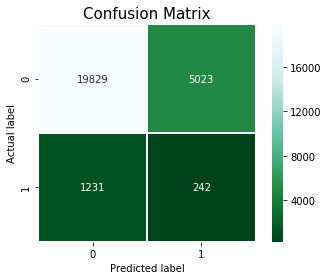

In [42]:
# Training
x = x_tr_all
y = y_tr_all
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

#######################
Evaluation metrics ####
#######################
Accuracy: 0.762
AUC Score: 0.471
Precision: 0.042
Precision Weighted: 0.885
Recall: 0.142
Recall Weighted: 0.762
F1: 0.065
F1 Weighted: 0.817
Prevelance: 0.059


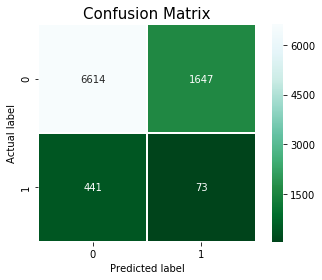

In [43]:
# Validatin
x = x_v
y = y_v
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

# Test Set Scoring

## General Function

In [44]:
def test_score(clf, x):
    
    print("Detailed classification report:")
    print()
    print("The model is trained and tuned on the training and validation sets..")
    print("The scores are computed on the test set.")
    print()
    y_true, y_pred = y_te, clf.predict(x)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(classification_report(y_true, y_pred, digits = 3))
    print()
    
    prevalence_te = '%.3f' %calc_prevalence(y_true)
    auc_score_te = '%.3f' %roc_auc_score(y_true, y_pred)
    print('AUC Score: ', auc_score_te)
    print('Positive Target Prevalence: ', prevalence_te)
    

In [45]:
def test_score_cv(clf, x):
    scoring = ['roc_auc', 'accuracy', 'balanced_accuracy', 'precision', 'recall', 'f1']
    
    results = cross_validate(estimator = clf,
                                          X = x,
                                          y = y_te,
                                          cv = 5,
                                          scoring = scoring)
    for metric_name in results.keys():
        average_score = np.average(results[metric_name])
        print('%s : %.3f' % (metric_name, average_score))
    
    prevalence_te = '%.3f' %calc_prevalence(y_te)
    print('positive target prevalence: ', prevalence_te)

## One Class SVM

#######################
Evaluation metrics ####
#######################
Accuracy: 0.911
AUC Score: 0.504
Precision: 0.069
Precision Weighted: 0.892
Recall: 0.043
Recall Weighted: 0.911
F1: 0.053
F1 Weighted: 0.901
Prevelance: 0.058


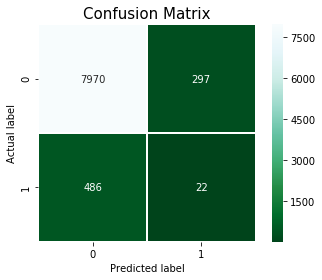

In [46]:
# Test
x = x_te
y = y_te
y_pred = svm.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)
pretty_cm(y_pred, y, [0, 1])

## Isolation Forest

#### AUC

#######################
Evaluation metrics ####
#######################
Accuracy: 0.752
AUC Score: 0.480
Precision: 0.048
Precision Weighted: 0.888
Recall: 0.173
Recall Weighted: 0.752
F1: 0.075
F1 Weighted: 0.811
Prevelance: 0.058


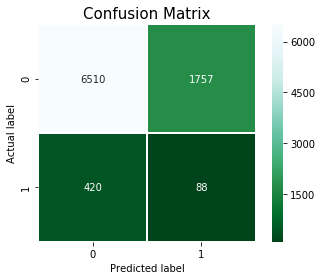

In [47]:
clf = clf_auc

# Test
x = x_te
y = y_te
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])

#### F1 Weighted

#######################
Evaluation metrics ####
#######################
Accuracy: 0.749
AUC Score: 0.483
Precision: 0.049
Precision Weighted: 0.888
Recall: 0.183
Recall Weighted: 0.749
F1: 0.078
F1 Weighted: 0.810
Prevelance: 0.058


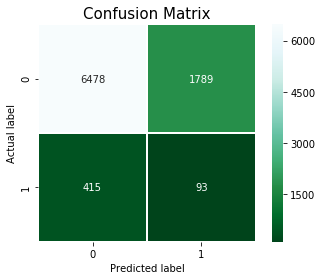

In [48]:
clf = clf_f1

# Test
x = x_te
y = y_te
y_pred = clf.predict(x)
y_pred = [1 if x == -1 else 0 for x in y_pred]
y_pred = pd.Series(y_pred)

pretty_cm(y_pred, y, [0, 1])